# Boston Average Housing Prices Analysis

## Purpose of Analysis and Methodology

The purpose of this analysis is to build a ML regression model which can, given a specific set of input data, predict the average house price for an area in Boston. This analysis uses a well-known and freely available dataset stored here: 

https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

We will look to analyse the data to find the most relevant features for house prices, and then test various ML models on the data to see which gives the best apparent fit for the data.

## Importing and Preparing the Data

Firstly, we need to configure Python and prepare the tool we need for the analysis. We then import the downloaded data, and  manipulate it into a format that we can insert into a Pandas dataframe, ready for analysis.

In [2]:
#Importing relevant libraries/models for use in analysis and setting up graph displays in Notebooks 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
%matplotlib inline

The data is stored in a text file where the relevant columns are separated by space, and go over two lines, along with a large explanatory section at the top which needs to be ignored. The header sample is shown below.

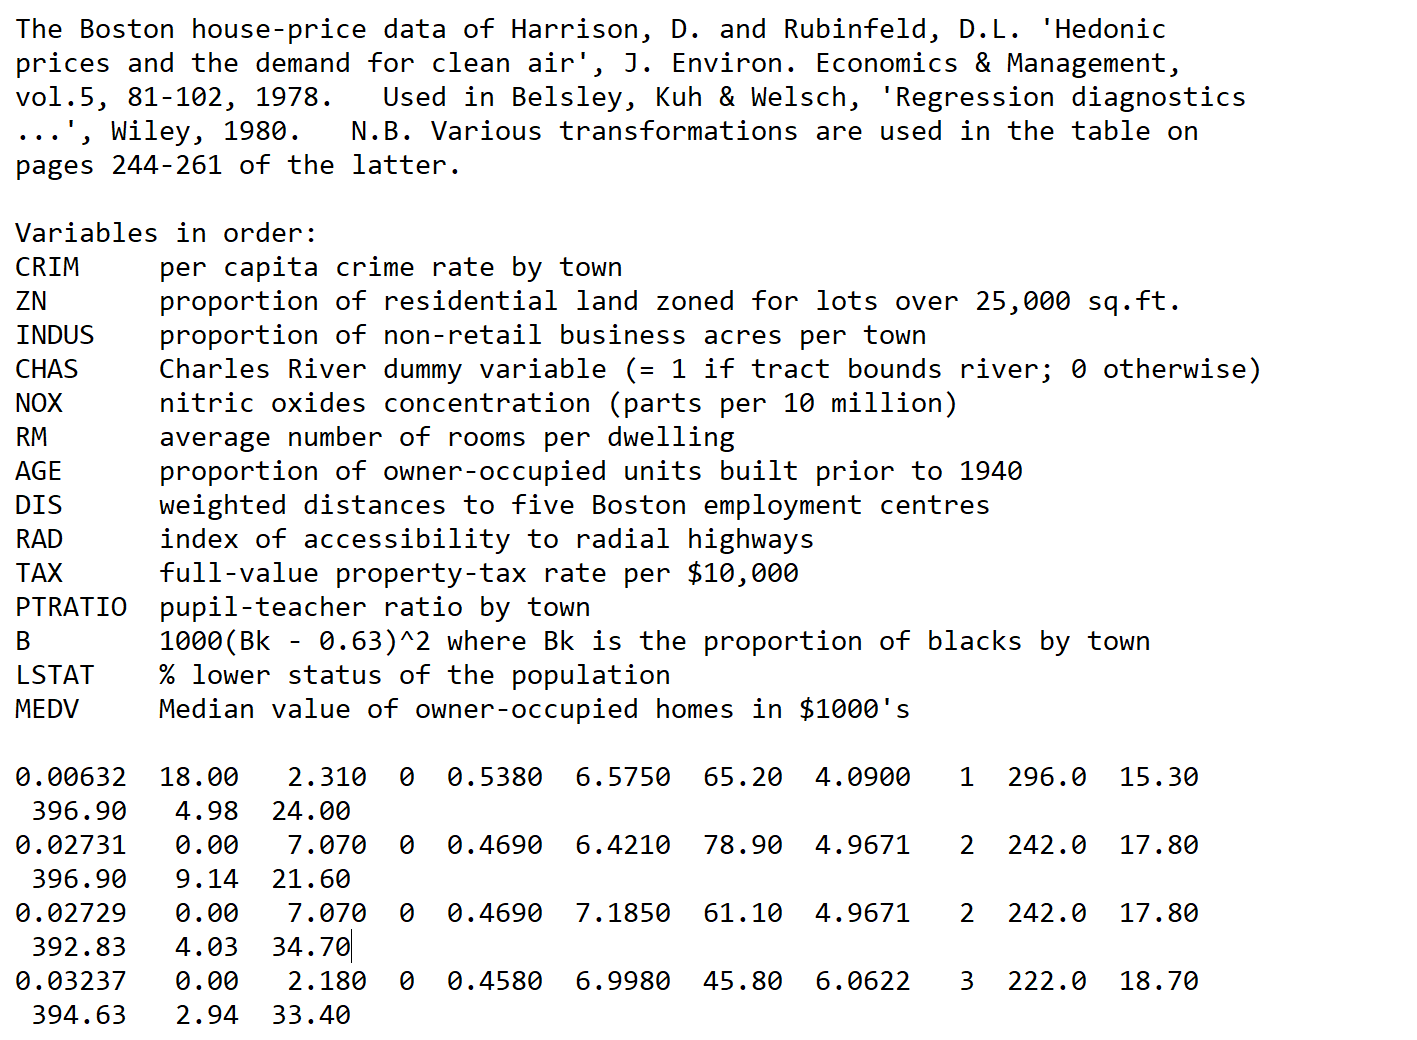

In [3]:
#Import the data
source = r'C:\Users\DaveMason\Documents\Data Science Projects\Boston Housing\boston.txt'

#Put data into a datafram, ignoring the explanatory section, and defining how columns are separated in the text
df0 = pd.read_csv(source, skiprows = range(0,21), sep='\s+', header = None, engine = 'python')


In [4]:
#Separate out odd/even rows into separate dataframes
df1 = df0[df0.index%2 == 0].reset_index(drop=True)
df2 = df0[df0.index%2 == 1].reset_index(drop=True)
df3 = df2[[0,1,2]]

#Define the column titles
columns = ['CRIM', 'ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

#Merge the dataframes back together to give one row per area.
df = pd.merge(df1, df3, left_index=True, right_index=True)
df.columns = columns

Below we can see that we now have a dataframe ready for analysis in the proper format.

In [5]:
#Show the first 5 rows of the final dataframe
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Exploratory Analysis of Data

Next we want to examine the dataset, look for any obvious issues, and do basic analysis for understanding correlations in the data.

Firstly we can use the describe method to examine the data and look for any obvious issues such as null values within the data. For each variable we appear to have 506 values, which indicates that there are no nulls in the dataset, so this makes life much easier.

Nothing else appears to immediately stand out as an issue, with the caveat that these features are all on very different scales, so we will want to standardise them later on, to avoid issues with this.

In [6]:
df.describe()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Producing histograms of the data we can look at the distributions of the data.

It appears that there are some features in the data that would ideally be discussed and understood with the people who have sourced the data to be sure we are understanding them properly, there are no errors in the data and to be clear on whether any assumptions we make will affect the outcome, and usage that our model is put to.

For example it appears that the industrial, parent/teacher ratio, zoning, and tax measures all have distinct peaks around specific values. It is likely that this is caused by Federal or local laws which mandate these kind of things, leading to spikes around certain values, but in an ideal world we would make sure that these weren't a result of collection/recording errors/etc.  

It also appears that the median house price has been capped at $50k as there is nothing above that, which does not seem likely.

However, as we don't have any way to do this, and this is a well used dataset, it seems best to assume that there are no errors.

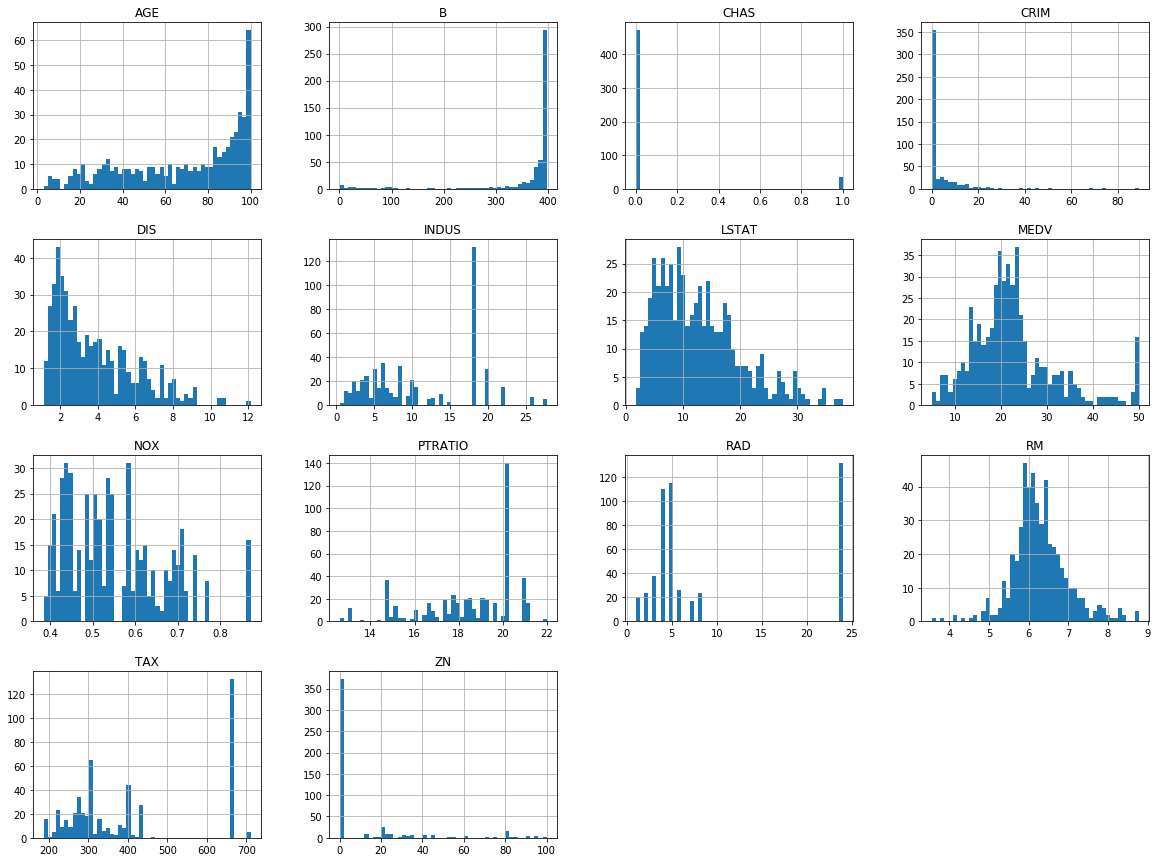

In [7]:
df.hist(bins = 50, figsize =(20,15))
plt.show()

We can now start looking for correlations in the data, but first we need to split the data into a training set, which we use to train the ML models on and for all further exploratory analysis, and a test data set which we set to one side and use for verification and testing purposes, once we have created our models and ensure that the patterns we have found in the test data are also present in this separate dataset.

I have used a standard 80/20 train/test split, setting a seed of 42 for the pseudo-random generator so we can replicate this split exactly in future.

In [8]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

#Create a copy of this training set to play with.
housing = train_set.copy()

Looking at the correlations between the Median house value and the various measures we can see that the most significant correlations are with the average number of rooms an area has, and also the '% of lower status population' in the area. As you would expect, the correlation is generally positive when the number of rooms increases, and negative when the proportion of lower status population increases.

In [9]:
corr_matrix = housing.corr()
corr_matrix["MEDV"].sort_values(ascending = False)

MEDV       1.000000
RM         0.710680
B          0.339918
ZN         0.309504
DIS        0.235114
CHAS       0.190642
AGE       -0.340216
CRIM      -0.380091
RAD       -0.387467
NOX       -0.415768
TAX       -0.459795
INDUS     -0.470546
PTRATIO   -0.491210
LSTAT     -0.736422
Name: MEDV, dtype: float64

Taking a smaller selection of features we can create a scatter matrix to visualise the correlations, and then create a couple of further charts, zooming in on the most important features.

From this it appears clear that the number of rooms and 'Lstat' features have the clearest correlations with the value of property. The number of rooms is a close to linear relationship, but the Lstat relationship is more of a curve. It is worth noting that there are some unusual cases where the value is at the maximum, but the number of rooms is lower. It seems likely that these are central city locations where expensive apartments, rather than houses, dominate however none of the other measures seem to capture this feature.

As you would expect, some of the other features do show some amount of correlation, but are a lot more scattered than the two main features.

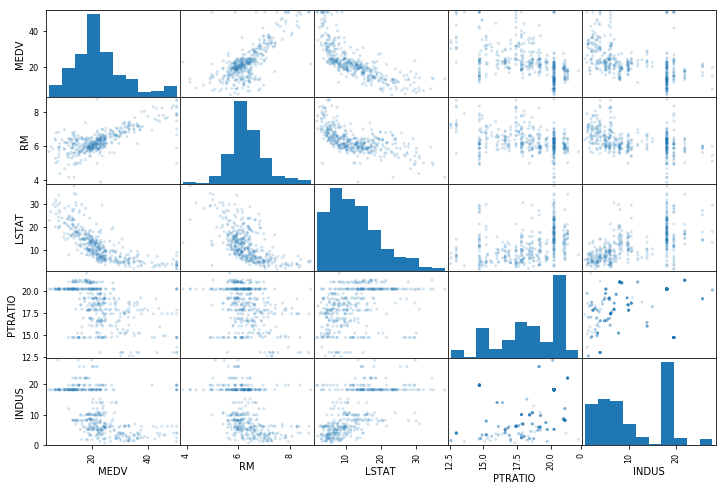

In [10]:
attributes = ["MEDV","RM", "LSTAT", "PTRATIO", "INDUS"]
scatter_matrix(housing[attributes], figsize = (12,8), alpha = 0.2);

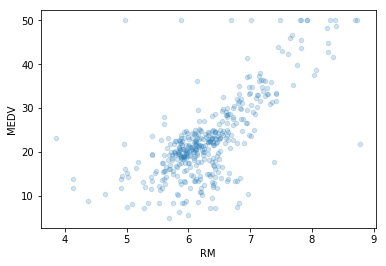

In [11]:
housing.plot(kind="scatter", x="RM", y="MEDV",alpha=0.2);

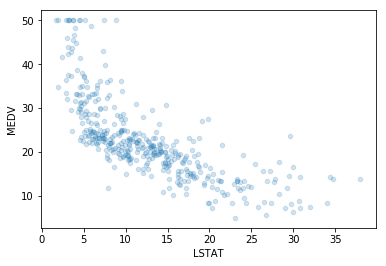

In [12]:
housing.plot(kind="scatter", x="LSTAT", y="MEDV", alpha=0.2);

## Building Regression Models

Now we have completed our initial analysis of the data and have an understanding of it, we can start to build some ML regression models to try and capture the patterns in the data, and automatically estimate the median value for a given area.

Firstly we need to remove the median value from our training set, and put it into a separate location to refer to later.

In [13]:
# Remove MEDV from the housing dataframe
housing = train_set.drop("MEDV", axis = 1)

# Create a 'labels' dataframe to store the median values
housing_labels = train_set["MEDV"].copy()

In [14]:
#It is good practice to set up a pipeline for transformations to our data. In this case we are only using one, a scaler
#which brings all features on to the similar scale, so they can be directly compared, but we can easily add more if required
pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

#We now apply this pipeline to the housing dataset to create the set we can train our models on
housing_tr = pipeline.fit_transform(housing)

In [15]:
#Looking at this array we can see it consists of numeric values on the same scale, so they can be easily compared directly
housing_tr

array([[ 1.28770177, -0.50032012,  1.03323679, ...,  0.84534281,
        -0.07433689,  1.75350503],
       [-0.33638447, -0.50032012, -0.41315956, ...,  1.20474139,
         0.4301838 , -0.5614742 ],
       [-0.40325332,  1.01327135, -0.71521823, ..., -0.63717631,
         0.06529747, -0.65159505],
       ...,
       [-0.40547014,  2.95931752, -1.30336132, ..., -0.59225149,
         0.37901005, -0.91069248],
       [ 0.85189733, -0.50032012,  1.03323679, ...,  0.84534281,
        -2.69458597,  1.52257036],
       [-0.38135592, -0.50032012, -0.35216694, ...,  1.15981657,
        -3.12158061, -0.25731635]])

In [29]:
#Firstly we will train a basic Multi-Variate Linear regression model
lin_reg = LinearRegression()
lin_reg.fit(housing_tr, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

We can now use this model to make some predictions for house values, and compare them directly to the 'actual' values, purely using data from the training dataset.

Looking at the output below the predictions and the labels look to be of roughly the same order, and generally the higher predicted values match higher actual values. However the third value is predicted to be considerably higher than the second, when in actual fact it is marginally lower.

We can also look at the root mean squared error (RMSE, one of several standard measures of accuracy), and see that this equates to around 4.65, we can use this to compare accuracy with other prediction models.

In [30]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = pipeline.transform(some_data)

In [31]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [10.96952405 19.41196567 23.06419602 12.1470648  18.3738116 ]


In [32]:
print("Labels:", list(some_labels))

Labels: [12.0, 19.9, 19.4, 13.4, 18.2]


In [33]:
housing_predictions = lin_reg.predict(housing_tr)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.6520331848801675

As an experiment we can now compare the Linear model with a Decision Tree model. However, when we do this we find it gives an RMSE of 0! This appears to be a clear case of over-fitting the data. We can see this if we use cross-validation (with 10 folds in this case) to test the model. By doing this we end up with an average RMSE of 4.88, which is worse than our linear model.

We could try tuning the model using hyper-parameters to improve this performance, but in general it is accepted that a Random Forest Regression model generally performs better (by creating many Decision Trees on random subsets of the data and then aggregating the results), so it seems to be a good idea to switch to that instead.

In [34]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_tr, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [35]:
housing_predictions = tree_reg.predict(housing_tr)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [36]:
scores = cross_val_score(tree_reg, housing_tr, housing_labels, scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [17]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [38]:
display_scores(tree_rmse_scores)

Scores: [3.68315215 4.05435628 4.66889029 7.11912573 6.18548705 3.75599521
 4.60727685 5.82134005 3.27318652 5.43946229]
Mean: 4.8608272431852235
Standard deviation: 1.1828667531936008


In [39]:
lin_scores = cross_val_score(lin_reg, housing_tr, housing_labels, scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [3.76298481 4.25110998 5.34719644 6.71464778 4.59265163 5.17395941
 4.43145447 4.5777583  3.6723473  5.77030866]
Mean: 4.829441880454279
Standard deviation: 0.8896329730748538


Below is the Random Forest model built using standard settings. We can see that it has an RMSE of 1.84, which appears very good, but possibly still overfitting. Using cross validation we see this value increase to an average of 3.65 (note that due to the random nature of this model, different results will come out each time it is run). So this appears to be a genuine improvement over the linear model.

In [40]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_tr, housing_labels)
housing_predictions = forest_reg.predict(housing_tr)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

C:\Users\DaveMason\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1.578018167396581

In [41]:
forest_scores = cross_val_score(forest_reg, housing_tr, housing_labels, scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [2.82259654 3.75773446 3.56405394 5.70914735 5.39940228 3.04747683
 4.80433216 2.69438629 2.73057595 4.70733205]
Mean: 3.9237037840882834
Standard deviation: 1.0875180256872512


In [42]:
#Saving the models into pickle files, so we can retrieve them at a later date.
joblib.dump(forest_reg, "forest_reg.pkl")

['forest_reg.pkl']

In [43]:
joblib.dump(tree_reg, "tree_reg.pkl")

['tree_reg.pkl']

In [44]:
joblib.dump(lin_reg, "lin_reg.pkl")

['lin_reg.pkl']

We can now try tuning some hyperparameters to see if we can improve this performance. First we set up a dictionary containing the variables and the values we want to try, then run these through the fitting process, returning the RMSE for each, in order to select an optimum setting.

In this case it returns that a max features of 4, 100 estimators, and not boot strapping gives the lowest RMSE. It should be said that due to the random nature of this model I found that running this several times gave different optimal settings, but the RMSE did not change hugely.

In [45]:
param_grid = [
    {'n_estimators' : [3, 10, 30, 50, 100, 1000], 'max_features' : [2, 4, 6, 8], 'bootstrap': [True, False]},
 #   {'bootstrap': [False], 'n_estimators' : [3, 10], 'max_features': [2,3,4]},
]

In [46]:
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                                  scoring = 'neg_mean_squared_error')
grid_search.fit(housing_tr, housing_labels)

C:\Users\DaveMason\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30, 50, 100, 1000], 'max_features': [2, 4, 6, 8], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [47]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 1000}

In [48]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [49]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4.330543974041958 {'bootstrap': True, 'max_features': 2, 'n_estimators': 3}
3.935221602325076 {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}
4.033751734155845 {'bootstrap': True, 'max_features': 2, 'n_estimators': 30}
4.013152827125001 {'bootstrap': True, 'max_features': 2, 'n_estimators': 50}
3.8386030941097444 {'bootstrap': True, 'max_features': 2, 'n_estimators': 100}
3.7700372200672385 {'bootstrap': True, 'max_features': 2, 'n_estimators': 1000}
4.5119079092217875 {'bootstrap': True, 'max_features': 4, 'n_estimators': 3}
4.005309625736792 {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}
3.6264088988488554 {'bootstrap': True, 'max_features': 4, 'n_estimators': 30}
3.5970380334188006 {'bootstrap': True, 'max_features': 4, 'n_estimators': 50}
3.699706196188936 {'bootstrap': True, 'max_features': 4, 'n_estimators': 100}
3.6305782904203125 {'bootstrap': True, 'max_features': 4, 'n_estimators': 1000}
4.457593859281197 {'bootstrap': True, 'max_features': 6, 'n_estima

From the Random Forest model we can also pull out the relative importance of the features being inputted.

As we can see RM and LStat show clearly as the most significant features, this is reassuring as it agrees with our previous analysis above.

In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.05808675, 0.00482164, 0.06666625, 0.00986273, 0.06856331,
       0.31717659, 0.02031178, 0.05780695, 0.01068843, 0.03082471,
       0.06077258, 0.02004987, 0.27436841])

In [51]:
attributes = list(housing)
sorted(zip(feature_importances, attributes), reverse=True)

[(0.31717659391575964, 'RM'),
 (0.27436841027244885, 'LSTAT'),
 (0.06856331246004477, 'NOX'),
 (0.06666625245916608, 'INDUS'),
 (0.060772577148511385, 'PTRATIO'),
 (0.05808674860178041, 'CRIM'),
 (0.057806945858801966, 'DIS'),
 (0.030824705583046477, 'TAX'),
 (0.020311781766727117, 'AGE'),
 (0.020049871497292975, 'B'),
 (0.01068843073356306, 'RAD'),
 (0.009862733193538833, 'CHAS'),
 (0.004821636509318298, 'ZN')]

Finally we can take this model with the optmised hyperparameters and confirm the average RMSE using cross validation, which shows an RMSE of 3.28, which is a small improvement on the untune version. We can now try the finished model out on the previously unseen test data to see how it performs. We find it actually gives an RMSE of 2.75, which is unusual, normally we would expect this to go up. Possibly this is a quirk of the random model, or the particular segment of the data which was separated out into a test set.

In [52]:
forest_reg = RandomForestRegressor(bootstrap=False, max_features=4, n_estimators = 1000)
forest_reg.fit(housing_tr, housing_labels)
housing_predictions = forest_reg.predict(housing_tr)
forest_scores = cross_val_score(forest_reg, housing_tr, housing_labels, scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [2.85043439 3.33148956 2.39031676 3.9005773  3.31069991 3.0092961
 3.66885561 2.48495673 2.29869457 5.56153858]
Mean: 3.280685952097817
Standard deviation: 0.9159546780760333


In [53]:
final_model = grid_search.best_estimator_
X_test = test_set.drop("MEDV", axis=1)
y_test = test_set["MEDV"].copy()
X_test_prepared = pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

In [54]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

2.7481696064086276

In [55]:
final_model

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

As an additional trial I decided to also try a Support Vector Machine regression model, to see how that performed in comparison. Initially we can see that is does not perform very well, with an RMSE of 5.03 on the test data in its untuned form. However, after some grid searching of hyperparameters this was reduced down to 2.98, making this the best performing model so far, the main difference appearing to be the use of the 'rbf' kernel. Unfortunately, using this kernel means that you are unable to get feature importances from the model, this is only available with the linear kernel.

In [18]:
SVR_reg = SVR(gamma = 'auto', kernel = 'linear')
SVR_reg.fit(housing_tr, housing_labels)
housing_predictions = SVR_reg.predict(housing_tr)
SVR_scores = cross_val_score(SVR_reg, housing_tr, housing_labels, scoring="neg_mean_squared_error",cv=10)
SVR_rmse_scores = np.sqrt(-SVR_scores)
display_scores(SVR_rmse_scores)

Scores: [3.93332507 4.19300192 5.3679937  6.98332567 5.46559102 5.72563818
 4.59031528 4.51054574 3.61158118 5.93469538]
Mean: 5.031601313954332
Standard deviation: 0.9899570724432144


In [19]:
param_grid = [
    {'kernel': ['rbf','linear'], 'C':[70, 80, 90 ,100, 110, 120, 130]},
 #   {'bootstrap': [False], 'n_estimators' : [3, 10], 'max_features': [2,3,4]},
]
SVR_reg = SVR(gamma = 'auto')
SVR_grid_search = GridSearchCV(SVR_reg, param_grid, cv = 10,
                                  scoring = 'neg_mean_squared_error')
SVR_grid_search.fit(housing_tr, housing_labels)

C:\Users\DaveMason\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf', 'linear'], 'C': [70, 80, 90, 100, 110, 120, 130]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [58]:
SVR_cvres = SVR_grid_search.cv_results_
for mean_score, params in zip(SVR_cvres["mean_test_score"], SVR_cvres["params"]):
    print(np.sqrt(-mean_score), params)

3.0552450154632913 {'C': 70, 'kernel': 'rbf'}
5.139644849062472 {'C': 70, 'kernel': 'linear'}
3.046117873714454 {'C': 80, 'kernel': 'rbf'}
5.139627150956032 {'C': 80, 'kernel': 'linear'}
3.0426934580854734 {'C': 90, 'kernel': 'rbf'}
5.140027905243054 {'C': 90, 'kernel': 'linear'}
3.042208384817325 {'C': 100, 'kernel': 'rbf'}
5.140028620145316 {'C': 100, 'kernel': 'linear'}
3.0454072805758585 {'C': 110, 'kernel': 'rbf'}
5.139719891053984 {'C': 110, 'kernel': 'linear'}
3.0522798564444047 {'C': 120, 'kernel': 'rbf'}
5.1396921051218785 {'C': 120, 'kernel': 'linear'}
3.0607876497883675 {'C': 130, 'kernel': 'rbf'}
5.139720322100223 {'C': 130, 'kernel': 'linear'}


In [20]:
SVR_grid_search.best_params_

{'C': 100, 'kernel': 'rbf'}

In [21]:
SVR_reg = SVR(gamma = 'auto', kernel = 'rbf', C = 100)
SVR_reg.fit(housing_tr, housing_labels)
housing_predictions = SVR_reg.predict(housing_tr)
SVR_scores = cross_val_score(SVR_reg, housing_tr, housing_labels, scoring="neg_mean_squared_error",cv=10)
SVR_rmse_scores = np.sqrt(-SVR_scores)
display_scores(SVR_rmse_scores)

Scores: [2.9821713  3.18389284 2.33906027 4.47113547 2.57477436 3.19229384
 2.84236002 2.40448939 2.48420228 3.31944032]
Mean: 2.979382010409474
Standard deviation: 0.5996941508881323


Now we have our final Support Vector Machine model we can apply it to the test set to see what the RMSE is. We find a score of 3.45, which is slightly higher than on the training set, but this is what you would expect in general.

In [27]:
final_model_SVR = SVR_reg
X_test = test_set.drop("MEDV", axis=1)
y_test = test_set["MEDV"].copy()
X_test_prepared = pipeline.transform(X_test)
final_predictions = final_model_SVR.predict(X_test_prepared)

In [28]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

3.4478447024065066

## Conclusion

So we now have two basic models that we could use for predicting house prices in Boston. Which we choose to use would depend on the final use case and how comfortable we are with the random aspect in the Random Forest model. Additional work that could be done is as follows:

* Train and test more models on the data, other more complicated models might produce better results.
* Given that only the LSTAT and Room variables seemed to be significant in general we could reduce the model to only look at those, then add additional variables in one at a time to see how they affect the result. Reduced numbers of variables would also have the advantage of requiring less data to be collected when a new area is to be estimated.
* Try re-running the analysis with the capped average price data-points removed, these could be skewing the model.
* Do further searches on hyper-parameters within our chosen models.

There are always more things to try! However, we have demonstrated the basic principles of regression type modelling so this seems like a good place to stop.